In [1]:
# This is the import cell
import sys
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.lines import Line2D
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
first = True
pd.set_option('display.max_columns', None)
pd.set_option("display.max_rows", 10)

# Here are my rc parameters for matplotlib
mpl.rc('font', serif='Helvetica Neue') 
mpl.rcParams.update({'font.size': 12})
mpl.rcParams['figure.figsize'] = 3.2, 2.8
mpl.rcParams['figure.dpi'] = 1000
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['lines.linewidth'] = 0.5
mpl.rcParams['axes.linewidth'] = 1.5

In [2]:
# Get the current path
if first:
    parent = os.getcwd()
os.chdir(parent)

# Grab file names from data folder
data = os.listdir('state_density')
try:
    data.remove('.DS_Store')
except:
    print(".DS_Store not in directory")

# Grab the MCS data
mcs_data = os.listdir('mcs_data')
try:
    data.remove('.DS_Store')
except:
    print(".DS_Store not in directory")
    
print(data)
print(mcs_data)

.DS_Store not in directory
.DS_Store not in directory
['phase_density_pa450_pb0_xa0_phi50.txt', 'phase_density_pa140_pb0_xa0_phi70.txt', 'phase_density_pa350_pb0_xa0_phi55.txt', 'phase_density_pa80_pb0_xa0_phi65.txt', 'phase_density_pa260_pb0_xa0_phi50.txt', 'phase_density_pa190_pb0_xa0_phi70.txt', 'phase_density_pa380_pb0_xa0_phi55.txt', 'phase_density_pa480_pb0_xa0_phi50.txt', 'phase_density_pa50_pb0_xa0_phi65.txt', 'phase_density_pa360_pb0_xa0_phi45.txt', 'phase_density_pa170_pb0_xa0_phi60.txt', 'phase_density_pa280_pb0_xa0_phi55.txt', 'phase_density_pa60_pb0_xa0_phi60.txt', 'phase_density_pa460_pb0_xa0_phi55.txt', 'phase_density_pa360_pb0_xa0_phi50.txt', 'phase_density_pa250_pb0_xa0_phi55.txt', 'phase_density_pa50_pb0_xa0_phi70.txt', 'phase_density_pa480_pb0_xa0_phi45.txt', 'phase_density_pa190_pb0_xa0_phi65.txt', 'phase_density_pa260_pb0_xa0_phi45.txt', 'phase_density_pa80_pb0_xa0_phi70.txt', 'phase_density_pa140_pb0_xa0_phi65.txt', 'phase_density_pa450_pb0_xa0_phi45.txt', 'phase_

In [3]:
# Some functions to get the relevant data from the filenames
def checkFile(fname, string):
    for i in xrange(len(fname)):
        if fname[i] == string[0]:
#             print"{} matches {}".format(fname[i], string[0])
            for j in xrange(1, len(string)):
                if fname[i + j] == string[j]:
#                     print"{} matches {}".format(fname[i+j], string[j])
                    if j == (len(string) - 1):
#                         print"Final match!"
                        return True
                else:
                    break
    return False
    
def txtValue(fname, string):
    out = ""
    index = 0
    for i in xrange(len(fname)):
        if fname[i] == string[0]:
            for j in xrange(1, len(string)):
                if fname[i + j] == string[j]:
                    if j == (len(string) - 1):
                        # Last index of search string
                        index = i + j
                else:
                    break
                        
    # First index of value
    index += 1
    mybool = True
    while mybool:
        if fname[index].isdigit():
            out = out + fname[index]
            index += 1
        elif fname[index] == ".":    
            if fname[index+1].isdigit():
                out = out + fname[index]
                index += 1
            else:
                mybool = False
        else:
            mybool = False
    return float(out)

# Sorting functions
def multiSort(arr1, arr2, arr3):
    """Sort an array the slow (but certain) way, returns original indices in sorted order"""
    # Doing this for PeR, PeS, xS in this case
    cpy1 = np.copy(arr1)
    cpy2 = np.copy(arr2)
    cpy3 = np.copy(arr3)
    ind = np.arange(0, len(arr1))
    for i in xrange(len(cpy1)):
        for j in xrange(len(cpy1)):
            # Sort by first variable
            if cpy1[i] > cpy1[j] and i < j:
                # Swap copy array values
                cpy1[i], cpy1[j] = cpy1[j], cpy1[i]
                cpy2[i], cpy2[j] = cpy2[j], cpy2[i]
                cpy3[i], cpy3[j] = cpy3[j], cpy3[i]
                # Swap the corresponding indices
                ind[i], ind[j] = ind[j], ind[i]
                
            # If first variable is equal, resort to second variable
            elif cpy1[i] == cpy1[j] and cpy2[i] > cpy2[j] and i < j:
                # Swap copy array values
                cpy1[i], cpy1[j] = cpy1[j], cpy1[i]
                cpy2[i], cpy2[j] = cpy2[j], cpy2[i]
                cpy3[i], cpy3[j] = cpy3[j], cpy3[i]
                # Swap the corresponding indices
                ind[i], ind[j] = ind[j], ind[i]
                
            elif cpy1[i] == cpy1[j] and cpy2[i] == cpy2[j] and cpy3[i] > cpy3[j] and i < j:
                # Swap copy array values
                cpy1[i], cpy1[j] = cpy1[j], cpy1[i]
                cpy2[i], cpy2[j] = cpy2[j], cpy2[i]
                cpy3[i], cpy3[j] = cpy3[j], cpy3[i]
                # Swap the corresponding indices
                ind[i], ind[j] = ind[j], ind[i]      
    return ind

def indSort(arr1, arr2):
    """Take sorted index array, use to sort array"""
    # arr1 is array to sort
    # arr2 is index array
    cpy = np.copy(arr1)
    for i in xrange(len(arr1)):
        arr1[i] = cpy[arr2[i]]

In [4]:
# Grab parameters, sort them
def computePeNet(PeS, PeF, xF):
    # Make sure particle fraction is in appropriate range
    if xF > 1.:
        xF /= 100.
    # Make sure slow species is actually slower
    if PeS > PeF:
        PeS, PeF = PeF, PeS
        xF = 1. - xF
    peNet = ((1. - xF) * PeS) + (xF * PeF)
    if PeF != 0:
        peRNet = (((1. - xF)*(np.sqrt(PeS/PeF))) + xF) * peNet
    else:
        peRNet = 0.
    return peNet, peRNet

peList = []
paList = []
pbList = []
xaList = []
epList = []
phiList = []
peNetList = []
peRNetList = []
for i in xrange(len(data)):
    if checkFile(data[i], "pe"):
        peList.append(txtValue(data[i], "pe"))
    else:
        peList.append(0)
    
    if checkFile(data[i], "pa"):
        paList.append(txtValue(data[i], "pa"))
    else:
        paList.append(0)
        
    if checkFile(data[i], "pb"):
        pbList.append(txtValue(data[i], "pb"))
    else:
        pbList.append(0)
        
    if checkFile(data[i], "xa"):
        xaList.append(txtValue(data[i], "xa"))
    else:
        xaList.append(100.)
        
    if checkFile(data[i], "ep"):
        epList.append(txtValue(data[i], "ep"))
    else:
        epList.append(1.)
        
    if checkFile(data[i], "phi"):
        phiList.append(txtValue(data[i], "phi"))
    else:
        phiList.append(60.)
    
    peNet, peRNet = computePeNet(paList[-1], pbList[-1], 100. - xaList[-1])
    peNetList.append(peNet)
    peRNetList.append(peRNet)

# Take a look at your lists
# print(peList)
# print(paList) 
# print(pbList) 
# print(xaList) 
# print(epList) 
# print(phiList)        

# Sort the arrays
if len(paList) > 1:
    # Sort them!
    print("Sorting... ")
    indArr = multiSort(paList, phiList, epList)
    indSort(data, indArr)
    indSort(peList, indArr)
    indSort(paList, indArr)
    indSort(pbList, indArr)
    indSort(xaList, indArr)
    indSort(epList, indArr)
    indSort(phiList, indArr)
    indSort(peNetList, indArr)
    indSort(peRNetList, indArr)

# Print the sorted array
print("Sorted textfiles:")
for i in data:
    print(i)
    
# Now that the data is sorted, read it into a dataframe
all_data = []
os.chdir('state_density')
for i in xrange(len(data)):
    df = pd.read_csv(data[i], sep='\s+', header=0)
    all_data.append(df)
os.chdir(parent)

# This is how you access the data at different levels
display(all_data[0])
# print(all_data[0]['Timestep'])
# print(all_data[0]['Timestep'][0])

Sorting... 
Sorted textfiles:
phase_density_pa0_pb0_xa0_phi45.txt
phase_density_pa0_pb0_xa0_phi50.txt
phase_density_pa0_pb0_xa0_phi55.txt
phase_density_pa0_pb0_xa0_phi60.txt
phase_density_pa0_pb0_xa0_phi65.txt
phase_density_pa0_pb0_xa0_phi70.txt
phase_density_pa10_pb0_xa0_phi45.txt
phase_density_pa10_pb0_xa0_phi50.txt
phase_density_pa10_pb0_xa0_phi55.txt
phase_density_pa10_pb0_xa0_phi60.txt
phase_density_pa10_pb0_xa0_phi65.txt
phase_density_pa10_pb0_xa0_phi70.txt
phase_density_pa20_pb0_xa0_phi45.txt
phase_density_pa20_pb0_xa0_phi50.txt
phase_density_pa20_pb0_xa0_phi55.txt
phase_density_pa20_pb0_xa0_phi60.txt
phase_density_pa20_pb0_xa0_phi65.txt
phase_density_pa20_pb0_xa0_phi70.txt
phase_density_pa30_pb0_xa0_phi45.txt
phase_density_pa30_pb0_xa0_phi50.txt
phase_density_pa30_pb0_xa0_phi55.txt
phase_density_pa30_pb0_xa0_phi60.txt
phase_density_pa30_pb0_xa0_phi65.txt
phase_density_pa30_pb0_xa0_phi70.txt
phase_density_pa40_pb0_xa0_phi45.txt
phase_density_pa40_pb0_xa0_phi50.txt
phase_density_

,Timestep,Gas-r=1.0,Liq-r=1.0,Gas-r=1.5,Liq-r=1.5,Gas-r=2.0,Liq-r=2.0,Gas-r=2.5,Liq-r=2.5,Gas-r=3.0,Liq-r=3.0,Gas-r=3.5,Liq-r=3.5,Gas-r=4.0,Liq-r=4.0,Gas-r=4.5,Liq-r=4.5,Gas-r=5.0,Liq-r=5.0
0,10.0,0.25,0.5,0.33,0.555,0.375,0.5,0.395,0.48,0.385,0.47,0.385,0.465,0.39,0.465,0.395,0.455,0.405,0.455
1,20.0,0.25,0.5,0.33,0.555,0.375,0.5,0.395,0.48,0.385,0.47,0.385,0.465,0.39,0.465,0.395,0.455,0.405,0.455
2,30.0,0.25,0.5,0.33,0.555,0.375,0.5,0.395,0.48,0.385,0.47,0.385,0.465,0.39,0.465,0.395,0.455,0.405,0.455
3,40.0,0.25,0.5,0.33,0.555,0.375,0.5,0.395,0.48,0.385,0.47,0.385,0.465,0.39,0.465,0.395,0.455,0.405,0.455
4,50.0,0.25,0.5,0.33,0.555,0.375,0.5,0.395,0.48,0.385,0.47,0.385,0.465,0.39,0.465,0.395,0.455,0.405,0.455
5,60.0,0.25,0.5,0.33,0.555,0.375,0.5,0.395,0.48,0.385,0.47,0.385,0.465,0.39,0.465,0.395,0.455,0.405,0.455
6,70.0,0.25,0.5,0.33,0.555,0.375,0.5,0.395,0.48,0.385,0.47,0.385,0.465,0.39,0.465,0.395,0.455,0.405,0.455
7,80.0,0.25,0.5,0.33,0.555,0.375,0.5,0.395,0.48,0.385,0.47,0.385,0.465,0.39,0.465,0.395,0.455,0.420,0.455
8,90.0,0.25,0.5,0.33,0.555,0.375,0.5,0.395,0.48,0.385,0.47,0.385,0.465,0.39,0.465,0.395,0.455,0.405,0.455
9,99.9,0.25,0.5,0.33,0.555,0.375,0.5,0.395,0.48,0.385,0.47,0.385,0.465,0.39,0.465,0.395,0.455,0.405,0.455


In [5]:
# Do the same for the MCS data
mcs_peList = []
mcs_paList = []
mcs_pbList = []
mcs_xaList = []
mcs_epList = []
mcs_phiList = []
mcs_peNetList = []
mcs_peRNetList = []
for i in xrange(len(mcs_data)):
    if checkFile(mcs_data[i], "pe"):
        mcs_peList.append(txtValue(mcs_data[i], "pe"))
    else:
        mcs_peList.append(0)
    
    if checkFile(mcs_data[i], "pa"):
        mcs_paList.append(txtValue(mcs_data[i], "pa"))
    else:
        mcs_paList.append(0)
        
    if checkFile(mcs_data[i], "pb"):
        mcs_pbList.append(txtValue(mcs_data[i], "pb"))
    else:
        mcs_pbList.append(0)
        
    if checkFile(mcs_data[i], "xa"):
        mcs_xaList.append(txtValue(mcs_data[i], "xa"))
    else:
        mcs_xaList.append(100.)
        
    if checkFile(mcs_data[i], "ep"):
        mcs_epList.append(txtValue(mcs_data[i], "ep"))
    else:
        mcs_epList.append(1.)
        
    if checkFile(mcs_data[i], "phi"):
        mcs_phiList.append(txtValue(mcs_data[i], "phi"))
    else:
        mcs_phiList.append(60.)
    
    peNet, peRNet = computePeNet(mcs_paList[-1], mcs_pbList[-1], 100. - mcs_xaList[-1])
    mcs_peNetList.append(peNet)
    mcs_peRNetList.append(peRNet)

# Take a look at your lists
# print(peList)
# print(paList) 
# print(pbList) 
# print(xaList) 
# print(epList) 
# print(phiList)        

# Sort the arrays
if len(mcs_paList) > 1:
    # Sort them!
    print("Sorting... ")
    indArr = multiSort(mcs_paList, mcs_phiList, mcs_epList)
    indSort(mcs_data, indArr)
    indSort(mcs_peList, indArr)
    indSort(mcs_paList, indArr)
    indSort(mcs_pbList, indArr)
    indSort(mcs_xaList, indArr)
    indSort(mcs_epList, indArr)
    indSort(mcs_phiList, indArr)
    indSort(mcs_peNetList, indArr)
    indSort(mcs_peRNetList, indArr)

# Print the sorted array
print("Sorted textfiles:")
for i in mcs_data:
    print(i)
    
# Now that the data is sorted, read it into a dataframe
mcs = []
os.chdir('mcs_data')
for i in xrange(len(mcs_data)):
    df = pd.read_csv(mcs_data[i], sep='\s+', header=0)
    mcs.append(df)
os.chdir(parent)

# This is how you access the data at different levels
display(mcs[0])
# print(all_data[0]['Timestep'])
# print(all_data[0]['Timestep'][0])

Sorting... 
Sorted textfiles:
MCS_pa0_pb0_xa0_phi45.txt
MCS_pa0_pb0_xa0_phi50.txt
MCS_pa0_pb0_xa0_phi55.txt
MCS_pa0_pb0_xa0_phi60.txt
MCS_pa0_pb0_xa0_phi65.txt
MCS_pa0_pb0_xa0_phi70.txt
MCS_pa10_pb0_xa0_phi45.txt
MCS_pa10_pb0_xa0_phi50.txt
MCS_pa10_pb0_xa0_phi55.txt
MCS_pa10_pb0_xa0_phi60.txt
MCS_pa10_pb0_xa0_phi65.txt
MCS_pa10_pb0_xa0_phi70.txt
MCS_pa20_pb0_xa0_phi45.txt
MCS_pa20_pb0_xa0_phi50.txt
MCS_pa20_pb0_xa0_phi55.txt
MCS_pa20_pb0_xa0_phi60.txt
MCS_pa20_pb0_xa0_phi65.txt
MCS_pa20_pb0_xa0_phi70.txt
MCS_pa30_pb0_xa0_phi45.txt
MCS_pa30_pb0_xa0_phi50.txt
MCS_pa30_pb0_xa0_phi55.txt
MCS_pa30_pb0_xa0_phi60.txt
MCS_pa30_pb0_xa0_phi65.txt
MCS_pa30_pb0_xa0_phi70.txt
MCS_pa40_pb0_xa0_phi45.txt
MCS_pa40_pb0_xa0_phi50.txt
MCS_pa40_pb0_xa0_phi55.txt
MCS_pa40_pb0_xa0_phi60.txt
MCS_pa40_pb0_xa0_phi65.txt
MCS_pa40_pb0_xa0_phi70.txt
MCS_pa50_pb0_xa0_phi45.txt
MCS_pa50_pb0_xa0_phi50.txt
MCS_pa50_pb0_xa0_phi55.txt
MCS_pa50_pb0_xa0_phi60.txt
MCS_pa50_pb0_xa0_phi65.txt
MCS_pa50_pb0_xa0_phi70.txt
MCS_

,Timestep,N_clusts,all_parts,thr_clusts,thr_parts,thr_c1000,thr_p1000
0,0.0,93103,100000,0,0,0,0
1,0.1,93455,100000,0,0,0,0
2,0.2,93561,100000,0,0,0,0
3,0.3,93544,100000,0,0,0,0
4,0.4,93629,100000,0,0,0,0
...,...,...,...,...,...,...,...
995,99.5,93771,100000,0,0,0,0
996,99.6,93751,100000,0,0,0,0
997,99.7,93797,100000,0,0,0,0
998,99.8,93774,100000,0,0,0,0


In [6]:
# Function to get conversion from timesteps to Brownian time
def computeTauPerTstep(epsilon, mindt=0.00001):
    if epsilon == 1.:
        mindt = 0.000001
    kBT = 1.0
    tstepPerTau = int(epsilon / (kBT * mindt))
    return 1. / tstepPerTau

# Grab the parameters from each file, store in a dataframe
headers = ['pe', 'peA', 'peB', 'xA', 'peR', 'peNet', 'peRNet', 'eps', 'phi', 'tauPer_dt']
params = pd.DataFrame(columns=headers)
for i in xrange(len(all_data)):
    pe = int(peList[i])
    pa = int(paList[i])
    pb = int(pbList[i])
    xa = float(xaList[i])
    if xa != 0 and xa != 100:
        if pa > pb:
            peR = float(pb) / float(pa)
        else:
            peR = float(pa) / float(pb)
    else:
        peR = 1.
    peNet = float(peNetList[i])
    peRNet = float(peRNetList[i])
    ep = int(epList[i])
    phi = float(phiList[i])
    if ep == 1:
        tauPerdt = computeTauPerTstep(ep, 0.000001)
    else:
        tauPerdt = computeTauPerTstep(ep)
    df = pd.DataFrame([[pe, pa, pb, xa, peR, peNet, peRNet, ep, phi, tauPerdt]], columns=headers)
    params = params.append(df, ignore_index = True)
display(params)

,pe,peA,peB,xA,peR,peNet,peRNet,eps,phi,tauPer_dt
0,0,0,0,0.0,1.0,0.0,0.0,1,45.0,0.000001
1,0,0,0,0.0,1.0,0.0,0.0,1,50.0,0.000001
2,0,0,0,0.0,1.0,0.0,0.0,1,55.0,0.000001
3,0,0,0,0.0,1.0,0.0,0.0,1,60.0,0.000001
4,0,0,0,0.0,1.0,0.0,0.0,1,65.0,0.000001
...,...,...,...,...,...,...,...,...,...,...
301,0,500,0,0.0,1.0,0.0,0.0,1,50.0,0.000001
302,0,500,0,0.0,1.0,0.0,0.0,1,55.0,0.000001
303,0,500,0,0.0,1.0,0.0,0.0,1,60.0,0.000001
304,0,500,0,0.0,1.0,0.0,0.0,1,65.0,0.000001


In [7]:
# Let's add columns to the time-resolved simulation data
for i in xrange(len(all_data)):
    # Ger rid of NaN in favor of 0
    all_data[i].fillna(0, inplace=True)

# display(all_data[0][0])
headers=list(all_data[0])
display(all_data[0])
print(all_data[0][headers[1]][0])
print(all_data[0][headers[2]][0])

,Timestep,Gas-r=1.0,Liq-r=1.0,Gas-r=1.5,Liq-r=1.5,Gas-r=2.0,Liq-r=2.0,Gas-r=2.5,Liq-r=2.5,Gas-r=3.0,Liq-r=3.0,Gas-r=3.5,Liq-r=3.5,Gas-r=4.0,Liq-r=4.0,Gas-r=4.5,Liq-r=4.5,Gas-r=5.0,Liq-r=5.0
0,10.0,0.25,0.5,0.33,0.555,0.375,0.5,0.395,0.48,0.385,0.47,0.385,0.465,0.39,0.465,0.395,0.455,0.405,0.455
1,20.0,0.25,0.5,0.33,0.555,0.375,0.5,0.395,0.48,0.385,0.47,0.385,0.465,0.39,0.465,0.395,0.455,0.405,0.455
2,30.0,0.25,0.5,0.33,0.555,0.375,0.5,0.395,0.48,0.385,0.47,0.385,0.465,0.39,0.465,0.395,0.455,0.405,0.455
3,40.0,0.25,0.5,0.33,0.555,0.375,0.5,0.395,0.48,0.385,0.47,0.385,0.465,0.39,0.465,0.395,0.455,0.405,0.455
4,50.0,0.25,0.5,0.33,0.555,0.375,0.5,0.395,0.48,0.385,0.47,0.385,0.465,0.39,0.465,0.395,0.455,0.405,0.455
5,60.0,0.25,0.5,0.33,0.555,0.375,0.5,0.395,0.48,0.385,0.47,0.385,0.465,0.39,0.465,0.395,0.455,0.405,0.455
6,70.0,0.25,0.5,0.33,0.555,0.375,0.5,0.395,0.48,0.385,0.47,0.385,0.465,0.39,0.465,0.395,0.455,0.405,0.455
7,80.0,0.25,0.5,0.33,0.555,0.375,0.5,0.395,0.48,0.385,0.47,0.385,0.465,0.39,0.465,0.395,0.455,0.420,0.455
8,90.0,0.25,0.5,0.33,0.555,0.375,0.5,0.395,0.48,0.385,0.47,0.385,0.465,0.39,0.465,0.395,0.455,0.405,0.455
9,99.9,0.25,0.5,0.33,0.555,0.375,0.5,0.395,0.48,0.385,0.47,0.385,0.465,0.39,0.465,0.395,0.455,0.405,0.455


0.25
0.5


In [8]:
%%capture
# Plot each column vs time for all files
for z in list(all_data[0]):
    for i in xrange(len(all_data)):
        plt.plot(all_data[i]['Timestep'], all_data[i][z], c=plt.cm.jet(params['peNet'][i] / max(params['peNet'])), label=(params['pe'][i]))
    plt.xlabel(r'Time $(\tau_{r})$')
    plt.ylabel(z)
    plt.title(z)
#     plt.legend()
    plt.show()

Totals


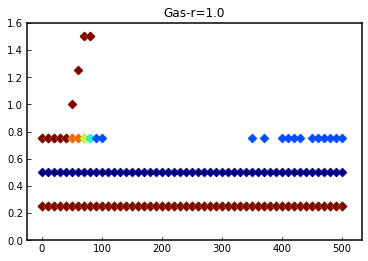

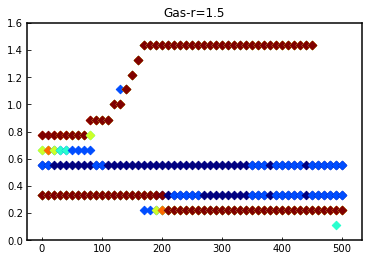

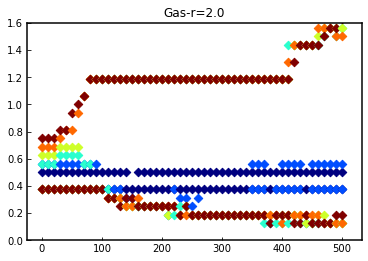

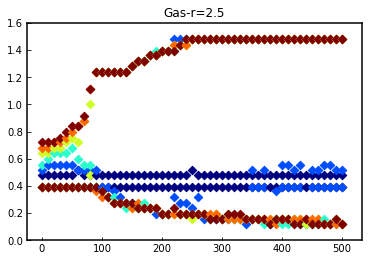

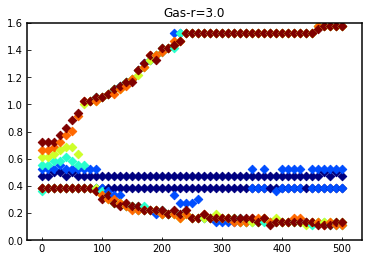

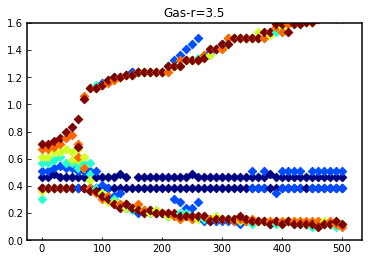

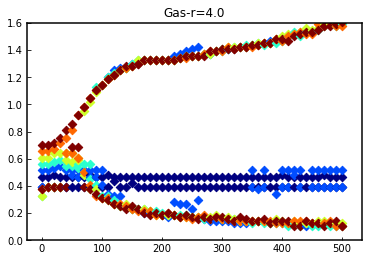

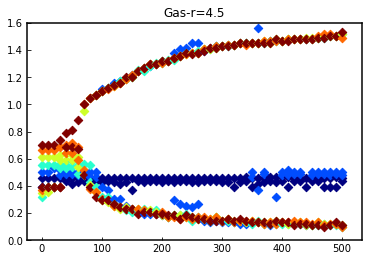

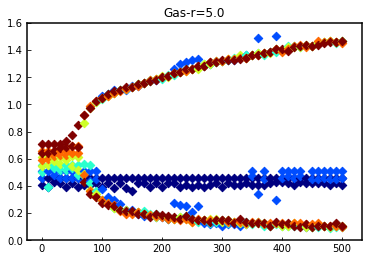

In [9]:
# Let's try and plot phiG and phiC vs peNet
print("Totals")

headers=list(all_data[0])
# for j in range(1, len(headers) - 1, 2):
#     # We want columns, phi= 45, 50, 55, 60, 65, 70
#     for i in xrange(len(all_data)):
#         plt.scatter(params['peA'][i], all_data[i][headers[j]][0], c=plt.cm.jet(params['peA'][i]/500.), marker='D')
#         plt.scatter(params['peA'][i], all_data[i][headers[j+1]][0], c=plt.cm.jet(params['peA'][i]/500.), marker='D')
#     plt.title(headers[j])
#     plt.ylim(0, 1.2)
#     plt.show()
    
for j in range(1, len(headers) - 1, 2):
    # We want columns, phi= 45, 50, 55, 60, 65, 70
    for i in xrange(len(all_data)):
        plt.scatter(params['peA'][i], all_data[i][headers[j]][0], c=plt.cm.jet((params['phi'][i]-45)/25.), marker='D')
        plt.scatter(params['peA'][i], all_data[i][headers[j+1]][0], c=plt.cm.jet((params['phi'][i]-45)/25.), marker='D')
    plt.title(headers[j])
    plt.ylim(0, 1.6)
    plt.show()

[45.0, 50.0, 55.0, 60.0, 65.0, 70.0]


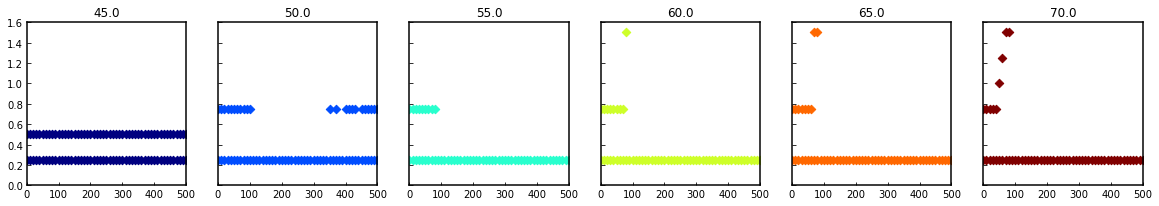

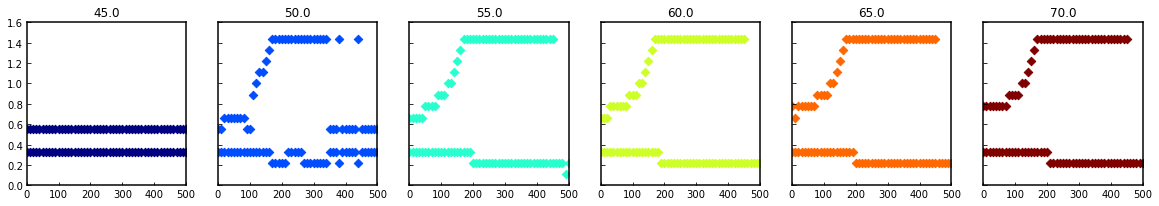

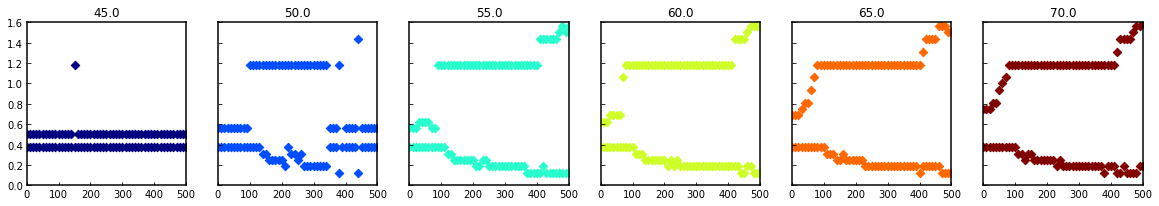

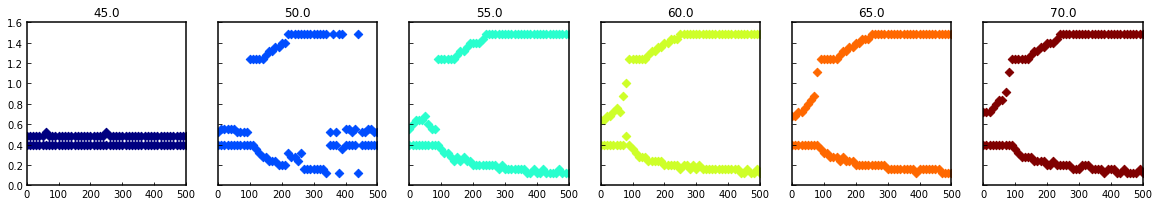

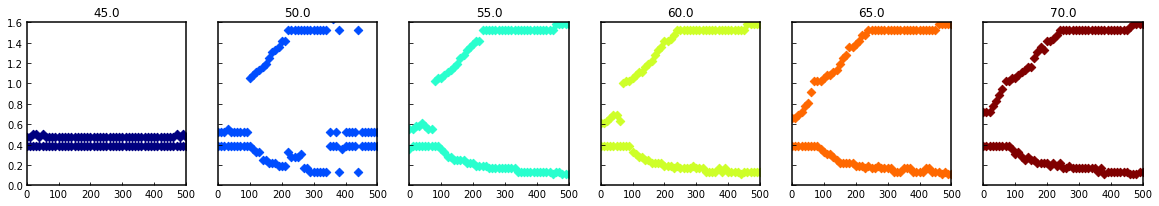

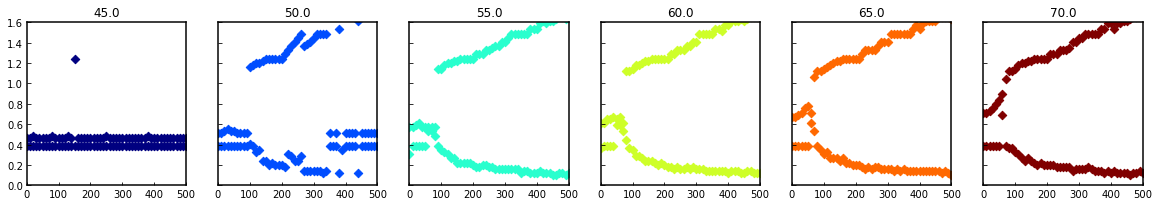

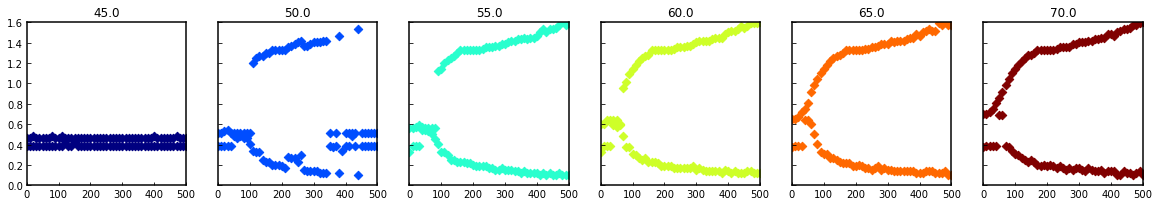

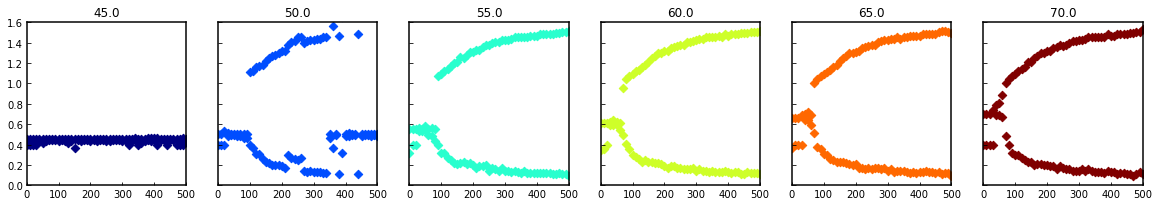

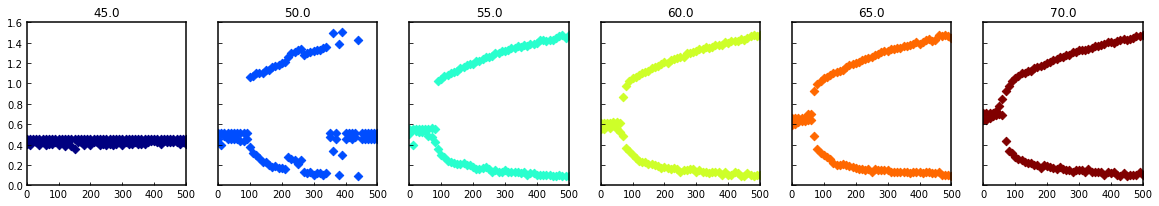

In [10]:
# Let's plot the first 4 densities side-by-side
uniquePhi = []
for i in phiList:
    if i not in uniquePhi:
        uniquePhi.append(i)
print(uniquePhi)

for j in range(1, len(headers) - 1, 2):
    # We want columns, phi= 45, 50, 55, 60, 65, 70
    fig, ax = plt.subplots(1, len(uniquePhi), figsize=(20, 3), sharey=True)
    for k in xrange(len(uniquePhi)):
        for i in xrange(len(all_data)):
            if params['phi'][i] == uniquePhi[k]:
                ax[k].scatter(params['peA'][i], all_data[i][headers[j]][0], c=plt.cm.jet((params['phi'][i]-45)/25.), marker='D')
                ax[k].scatter(params['peA'][i], all_data[i][headers[j+1]][0], c=plt.cm.jet((params['phi'][i]-45)/25.), marker='D')
        ax[k].set_xlim(0, 500.)
        ax[k].set_ylim(0, 1.6)
        ax[k].set_title(uniquePhi[k])
    plt.subplots_adjust(hspace=0.5)
    plt.show()


[45.0, 50.0, 55.0, 60.0, 65.0, 70.0]


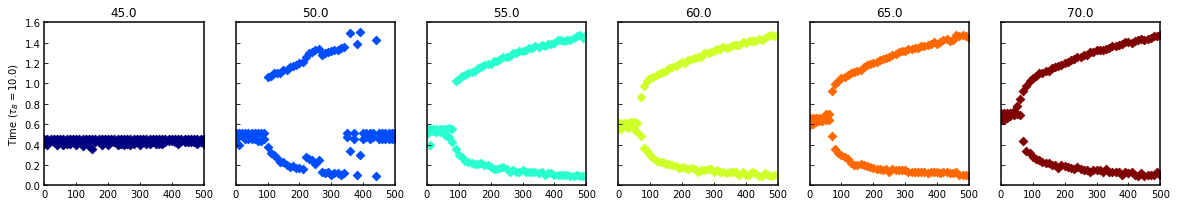

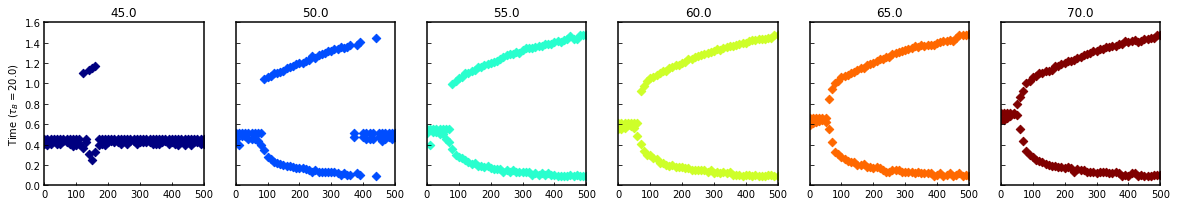

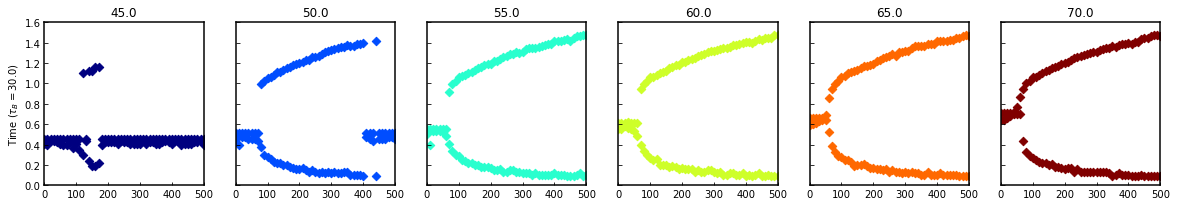

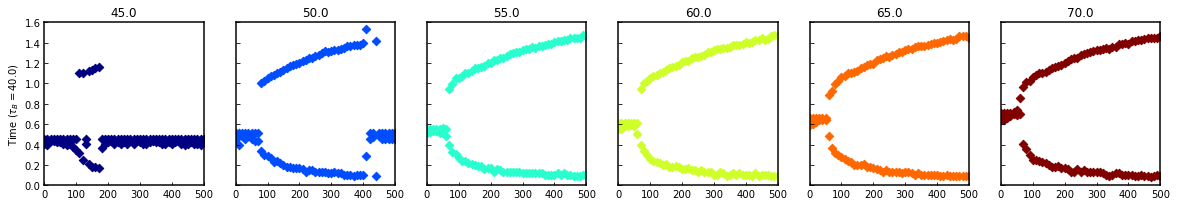

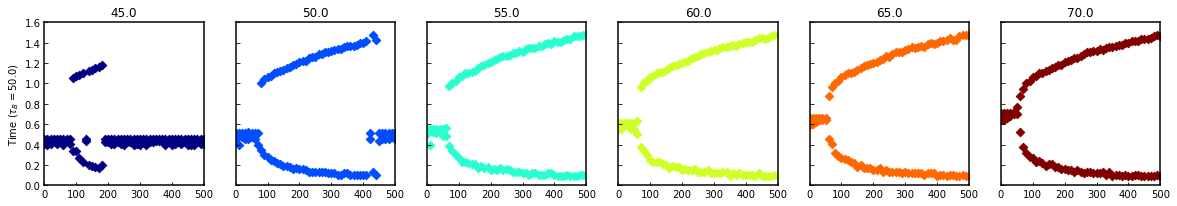

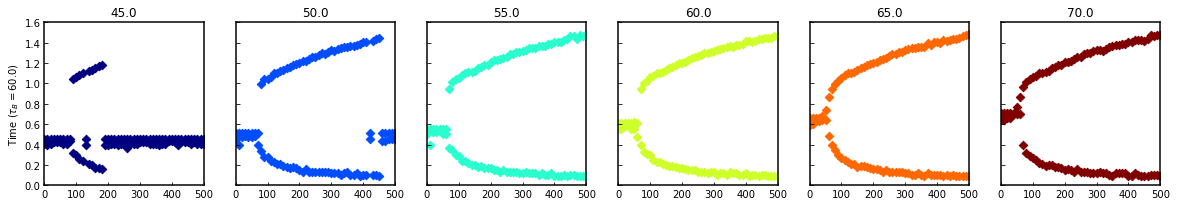

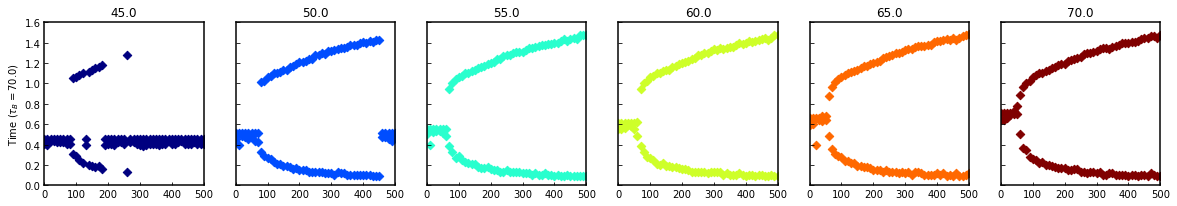

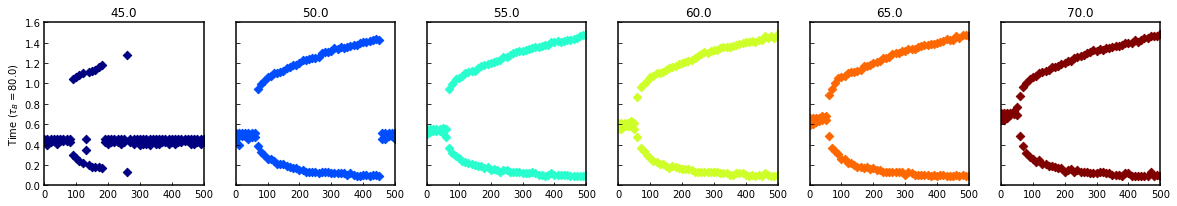

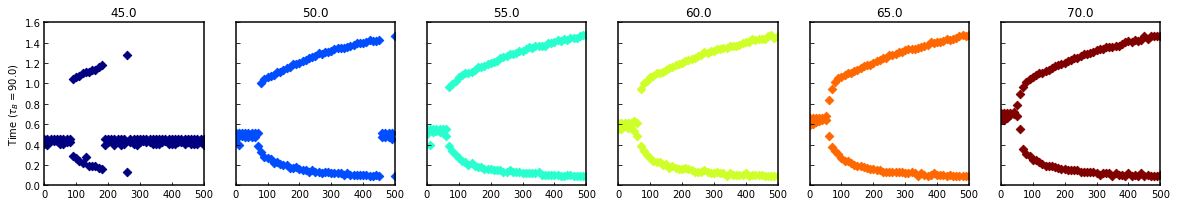

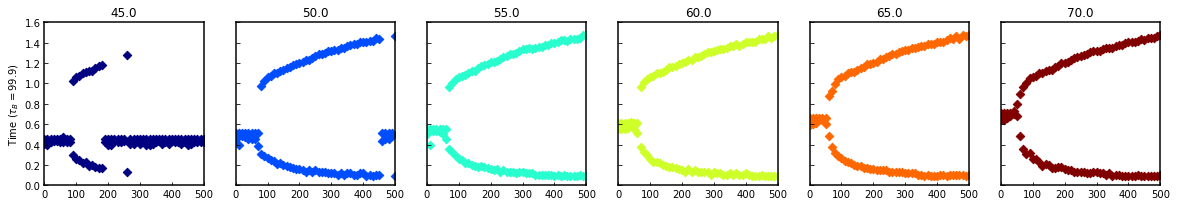

In [11]:
# Only take the r=5 search distance
uniquePhi = []
for i in phiList:
    if i not in uniquePhi:
        uniquePhi.append(i)
print(uniquePhi)


for j in range(len(headers)-2, len(headers) - 1, 2):
    # We want each time slice
    for m in xrange(len(all_data[0])):
        # We want columns, phi= 45, 50, 55, 60, 65, 70
        fig, ax = plt.subplots(1, len(uniquePhi), figsize=(20, 3), sharey=True)
        for k in xrange(len(uniquePhi)):
            for i in xrange(len(all_data)):
                if params['phi'][i] == uniquePhi[k]:
                    ax[k].scatter(params['peA'][i], all_data[i][headers[j]][m], c=plt.cm.jet((params['phi'][i]-45)/25.), marker='D')
                    ax[k].scatter(params['peA'][i], all_data[i][headers[j+1]][m], c=plt.cm.jet((params['phi'][i]-45)/25.), marker='D')
            ax[k].set_xlim(0, 500.)
            ax[k].set_ylim(0, 1.6)
            ax[k].set_title(uniquePhi[k])
        ax[0].set_ylabel(r'Time $(\tau_{B}=$' + str(all_data[0]['Timestep'][m]) + r'$)$')
        plt.subplots_adjust(hspace=0.5)
        plt.show()


['Timestep', 'N_clusts', 'all_parts', 'thr_clusts', 'thr_parts', 'thr_c1000', 'thr_p1000']


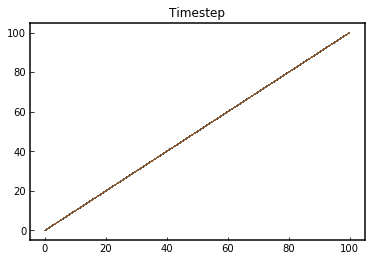

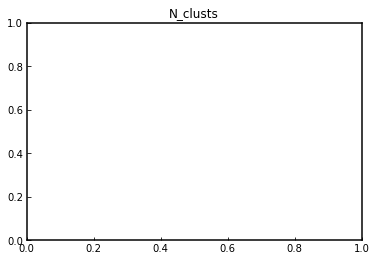

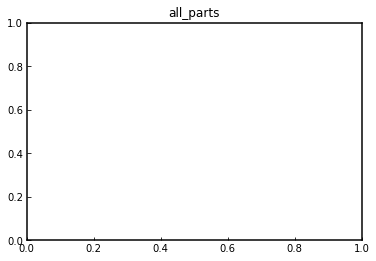

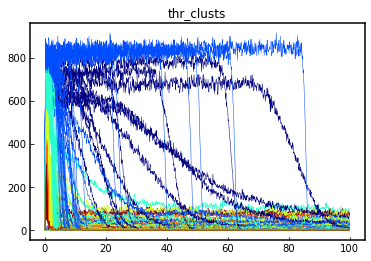

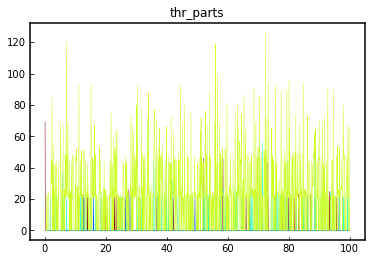

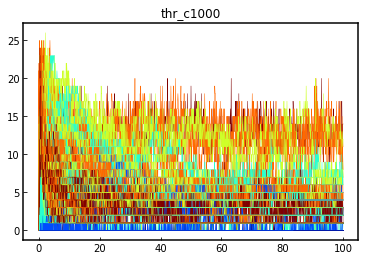

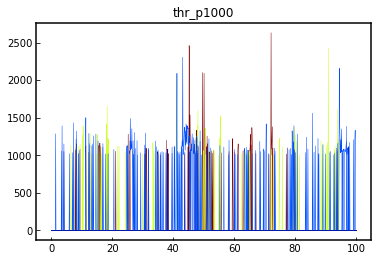

In [18]:
# Now let's look at the MCS data
mcs_headers = list(mcs[0])
print(mcs_headers)

for i in mcs_headers:
    for j in xrange(len(mcs)):
        if mcs[j][i].iloc[-1] < 100:  
            plt.plot(mcs[j]['Timestep'], mcs[j][i], c=plt.cm.jet((params['phi'][j]-45)/25.))
    plt.title(str(i))
#     plt.ylim(0, 100)
    plt.show()


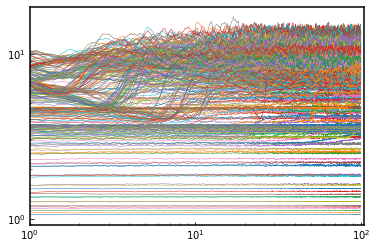

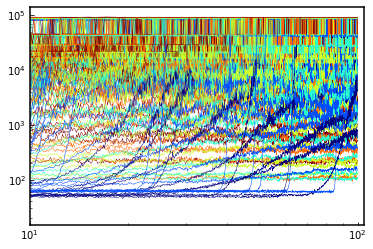

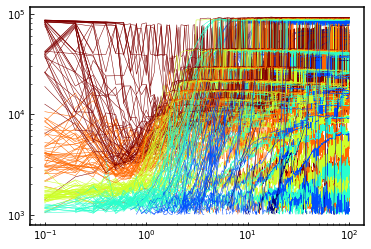

In [16]:
# Let's compute and look at the MCS
mcs_raw = []
mcs_thresh = []
mcs_1000 = []
for i in xrange(len(mcs)):
    mcs_raw.append(mcs[i]['all_parts'] / mcs[i]['N_clusts'])
    mcs_thresh.append(mcs[i]['thr_parts'] / mcs[i]['thr_clusts'])
    mcs_1000.append(mcs[i]['thr_p1000'] / mcs[i]['thr_c1000'])
    
for i in xrange(len(mcs)):
    plt.plot(mcs[i]['Timestep'], mcs_raw[i])
plt.xlim(1,)
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
plt.show()

for i in xrange(len(mcs)):
    if mcs_thresh[i].iloc[-1] > 100:
        plt.plot(mcs[i]['Timestep'], mcs_thresh[i], c=plt.cm.jet((params['phi'][i]-45)/25.))
plt.xlim(10,)
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
plt.show()

for i in xrange(len(mcs)):
#     if mcs_thresh[i].iloc[-1] > 100:
    plt.plot(mcs[i]['Timestep'], mcs_1000[i], c=plt.cm.jet((params['phi'][i]-45)/25.))
# plt.xlim(10,)
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
plt.show()


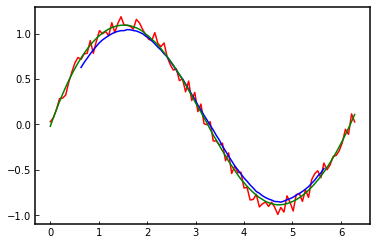

In [44]:
# Let's write a moving average for the MCS data
def movingAverage(inList, window=10):
    '''Read in the list to process and the window to average over'''
    side = window / 2
    outList = []
    for i in range(side, len(inList) - side):
        outList.append(np.mean(inList[i-side:i+side]))
    return outList

# Test the function
x = np.linspace(0,2*np.pi,100)
y = np.sin(x) + np.random.random(100) * 0.2
win = 20
smoothed = movingAverage(y, win)
import scipy.signal
smoothedSav = scipy.signal.savgol_filter(y, 51, 3)
plt.plot(x, y, c='r', lw=1.5)
plt.plot(x[win/2:len(x)-(win/2)], smoothed, c='b', lw=1.5)
plt.plot(x, smoothedSav, c='g', lw=1.5)
plt.show()

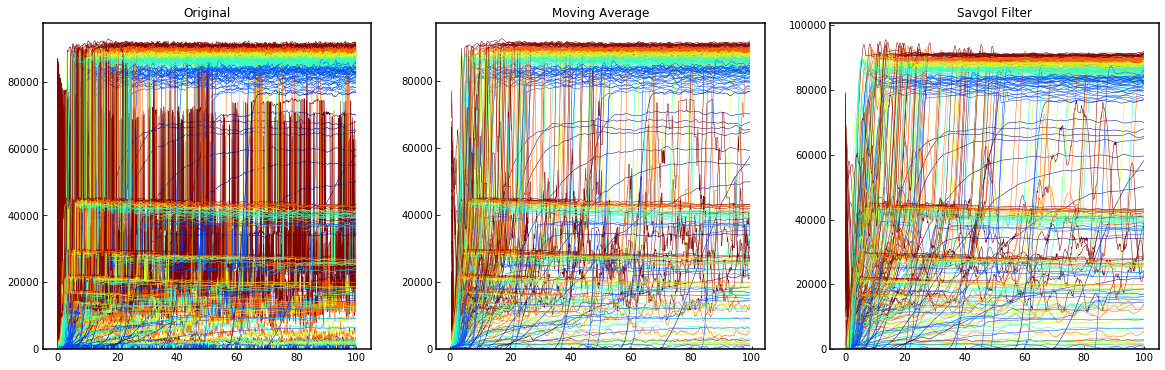

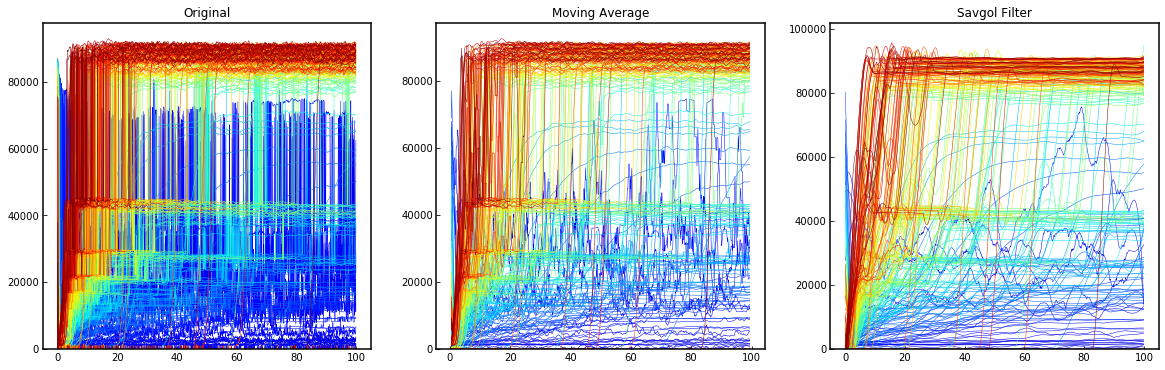

In [68]:
# Test it with data
win = 10
side = win / 2
fig, ax = plt.subplots(1, 3, figsize=(20, 6))
for i in xrange(len(mcs)):
    mcs_1000[i].fillna(0, inplace=True)
    ax[0].plot(mcs[i]['Timestep'], mcs_1000[i], c=plt.cm.jet((params['phi'][i]-45)/25.))
    smoothed = movingAverage(mcs_1000[i], win)
    ax[1].plot(mcs[i]['Timestep'][side:len(mcs[i]['Timestep'])-side], smoothed, c=plt.cm.jet((params['phi'][i]-45)/25.))
    smoothedSav = scipy.signal.savgol_filter(mcs_1000[i], 51, 3)
    ax[2].plot(mcs[i]['Timestep'], smoothedSav, c=plt.cm.jet((params['phi'][i]-45)/25.))
# plt.xlim(10,)
ax[0].set_title('Original')
ax[1].set_title('Moving Average')
ax[2].set_title('Savgol Filter')
ax[0].set_ylim(0,)
ax[1].set_ylim(0,)
ax[2].set_ylim(0,)
# ax[0].set_xscale('log')
# ax[0].set_yscale('log')
# ax[1].set_xscale('log')
# ax[1].set_yscale('log')
# ax[2].set_xscale('log')
# ax[2].set_yscale('log')
plt.show()

# Test it with data
win = 10
side = win / 2
fig, ax = plt.subplots(1, 3, figsize=(20, 6))
for i in xrange(len(mcs)):
    mcs_1000[i].fillna(0, inplace=True)
    ax[0].plot(mcs[i]['Timestep'], mcs_1000[i], c=plt.cm.jet(params['peA'][i]/500.))
    smoothed = movingAverage(mcs_1000[i], win)
    ax[1].plot(mcs[i]['Timestep'][side:len(mcs[i]['Timestep'])-side], smoothed, c=plt.cm.jet(params['peA'][i]/500.))
    smoothedSav = scipy.signal.savgol_filter(mcs_1000[i], 101, 3)
    ax[2].plot(mcs[i]['Timestep'], smoothedSav, c=plt.cm.jet(params['peA'][i]/500.))
# plt.xlim(10,)
ax[0].set_title('Original')
ax[1].set_title('Moving Average')
ax[2].set_title('Savgol Filter')
ax[0].set_ylim(0,)
ax[1].set_ylim(0,)
ax[2].set_ylim(0,)
# ax[0].set_xscale('log')
# ax[0].set_yscale('log')
# ax[1].set_xscale('log')
# ax[1].set_yscale('log')
# ax[2].set_xscale('log')
# ax[2].set_yscale('log')
plt.show()